In [1]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

In [2]:
train.head()

,Unnamed: 0,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,182,PAL0809,31,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,192,PAL0809,41,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,223,PAL0708,4,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,234,PAL0708,15,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,185,PAL0809,34,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


1. Explore

/Users/lindseyschweitzer/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lindseyschweitzer/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


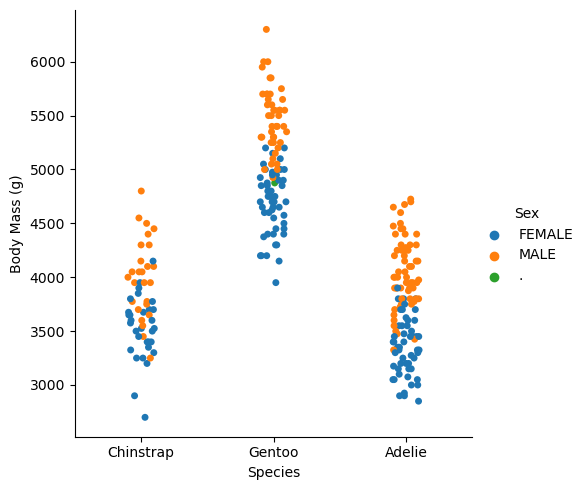

In [33]:
import seaborn as sns

# body mass vs specie with colors for gender
# slightly advanced syntax: 
# replace the column with the first word in each entry
train["Species"] = train["Species"].str.split().str.get(0)

sns.catplot(data=train, x="Species", y="Body Mass (g)", hue="Sex")

In [ ]:
Description of plot:Include axis labels and legends.
Help you draw conclusions about what features you are going to try using for your model.
Be accompanied by discussion of what you learned and how you will use it in modeling. Most figures and tables are worth at least one short paragraph of discussion.

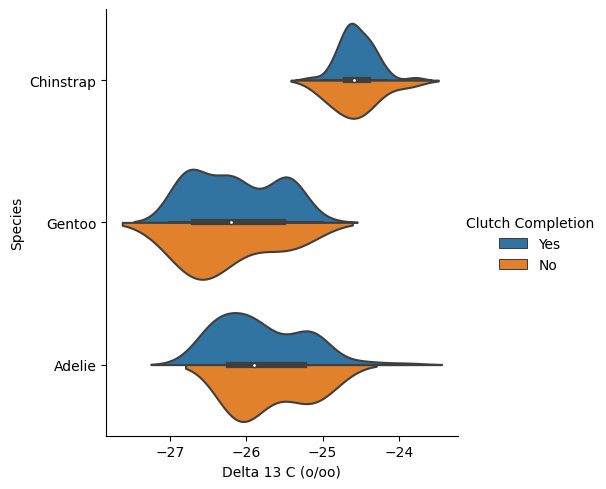

In [34]:
sns.catplot(data=train, kind="violin", x="Delta 13 C (o/oo)", y="Species", hue="Clutch Completion", split=True)

Description of catplot:

In [ ]:
table = train.groupby(['Species', 'Sex']).aggregate({'Body Mass (g)' : ['min', 'max','mean']})
print(table)

Description of table:

2. Model: Find three features of the data and a model trained on those features which achieves 100% testing accuracy. You must obtain your three features through a reproducible process. That is, you can’t just pick them: you need to code up some kind of search in order to obtain them.
One feature must be qualitative (like Island or Clutch Completion).
The other two features must be quantitative (like Body Mass (g) or Culmen Depth (mm)).

In [26]:
#Data Preparation to prepare the quantitative columns of our data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

In [28]:
X_train.head()

,Unnamed: 0,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,182,40.9,16.6,187.0,3200.0,9.08458,-24.54903,False,True,False,True,False,True,True,False
1,192,49.0,19.5,210.0,3950.0,9.53262,-24.66867,False,True,False,True,False,True,False,True
2,223,50.0,15.2,218.0,5700.0,8.25540,-25.40075,True,False,False,True,False,True,False,True
3,234,45.8,14.6,210.0,4200.0,7.79958,-25.62618,True,False,False,True,False,True,True,False
4,185,51.0,18.8,203.0,4100.0,9.23196,-24.17282,False,True,False,True,False,True,False,True


In [61]:
# iterative search to find the best markers

from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC
import numpy as np

# these are not actually all the columns: you'll 
# need to add any of the other ones you want to search for
all_qual_cols = ["Clutch Completion", "Sex", "Island",'Stage_Adult, 1 Egg Stage']
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)','Body Mass (g)','Delta 15 N (o/oo)','Delta 13 C (o/oo)',]

bestLRScore = 0
bestLRCols=[]
bestDTCScore = 0
bestDTCCols=[]
bestSVMScore = 0
bestSVMCols=[]

for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 
    # you could train models and score them here, keeping the list of 
    # columns for the model that has the best score. 

    # this counts as 3 features because the two Clutch Completion 
    # columns are transformations of a single original measurement. 
    # you should find a way to automatically select some better columns
    # as suggested in the code block above

    #LogisticRegression
    LR = LogisticRegression(max_iter=2000000000000000000)
    
    LR.fit(X_train[cols], y_train)
    # LRScore = LR.score(X_train[cols], y_train)
    
    LRScore = cross_val_score(LR, X_train[cols], y_train, cv=5).mean()
    
    if(LRScore > bestLRScore):
      bestLRScore = LRScore
      bestLRCols = cols
      
    #DecisionTreeClassifier
    DTC = DecisionTreeClassifier()
    
    DTC.fit(X_train[cols], y_train)
    # DTCScore = DTC.score(X_train[cols], y_train)
    
    param_grid = { 'max_depth': [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None ]} #amount of params, none is no max depth
    
    tree = DecisionTreeClassifier()
    grid_search = GridSearchCV(tree, param_grid, cv=5)
    grid_search.fit(X_train[cols], y_train)
    DTCScore  = grid_search.best_score_
        
    if(DTCScore > bestDTCScore):
      bestDTCScore = DTCScore
      bestDTCCols = cols
      bestDTCDepth = grid_search.best_params_
      
    #SVC
    
    for gamma in 10.0 ** np.arange(-5, 5):

      SVM = SVC(gamma = gamma)
      SVM.fit(X_train[cols], y_train)
      
      SVMScore = cross_val_score(SVM, X_train[cols], y_train, cv=5).mean()
      
      if(SVMScore > bestSVMScore):
        bestSVMScore = SVMScore
        bestSVMCols = cols
        

  
print(bestLRCols, ":", bestLRScore)
print("best max depth:", bestDTCDepth)
print(bestDTCCols, ":", bestDTCScore)
print(bestSVMCols, ":", bestSVMScore)

    

['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Culmen Depth (mm)'] : 0.9883107088989442
best max depth: {'max_depth': 6}
['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Flipper Length (mm)'] : 0.9804675716440421
['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Culmen Depth (mm)'] : 0.9805429864253394
